# Project Final Report: Predicting subscription status
Group number: 25

Authors: Dylan Lucas, Julie Wang, Yingnian Le

Output: html_document

In [1]:
# load packages
library(tidyverse)
library(tidymodels)
library(lubridate)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Introduction:

A research group at UBC, led by Frank Wood, has set up a Minecraft server where they're aiming to create an advanced artificial intelligence that can not only respond to speech, but also behave in a virtual space like Minecraft, just like humans. (Pacific Laboratory of Artificial Intelligence, 2025) To do this, they're collecting data on how humans navigate the Minecraft world.

They need help targeting their use of resources to handle the number of players that sign up. There are three questions of interest:
- Question 1: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?
- Question 2: We would like to know which "kinds" of players are most likely to contribute a large amount of data so that we can target those players in our recruiting efforts.
- Question 3: We are interested in demand forecasting, namely, what time windows are most likely to have large number of simultaneous players. This is because we need to ensure that the number of licenses on hand is sufficiently large to accommodate all parallel players with high probability. 

**In this report, we are trying to answer Question 1.** Specifically, can player experience level, playtime, gender, and/or age predict whether a player subscribes to the newsletter? (**NOTE: discuss what specific question we want to do. we don't have to use all the variables, we can pick and choose. we could also explore predictor variable selection as presented in chapter 6.8 of the textbook?**)

**NOTE:** Although the research question includes experience and gender as potential predictors, these variables are categorical. The KNN algorithm can only operate on numeric predictors because it relies on distance computations. The textbook Data Science: A First Introduction does not introduce transformations that would allow categorical variables to be appropriately incorporated. Therefore, in accordance with the textbook's methods, we restrict the KNN model to numeric predictors only (played_hours and Age).
Experience and gender are still examined descriptively in the exploratory analysis, but are not included in the KNN classification model.

We've been given data on the players that have signed up (players.csv), as well as their corresponding play sessions on the server (sessions.csv). As we are looking at player characteristics and behaviours, we will only be looking at players.csv.

players.csv: (table from Yingnian)
| Variable     | Type        | Description                                                                 |
|---------------|-------------|------------------------------------------------------------------------------|
| experience    | Categorical | Player experience level (e.g., “Amateur”, “Pro”, “Veteran”)                 |
| subscribe     | Logical     | Whether the player subscribed to the game-related newsletter (TRUE/FALSE)   |
| hashedEmail   | String      | Unique hashed identifier for each player                                    |
| played_hours  | Numeric     | Total number of hours the player spent in the game                          |
| name          | String      | Player’s name                                                               |
| gender        | Categorical | Player gender                                                               |
| Age           | Numeric     | Player age                                                                  |

**Note:**
Although experience and gender are conceptually categorical variables, in the raw unwrangled players.csv file they appear as character strings. These variables were therefore converted to factors during data wrangling, so that the modelling functions (especially KNN) can correctly interpret their categorical structure.

There are 196 observations and 7 variables. 
The average play time is 5.85 hours, and the average age is 21.14 years. (Summary statistics are only given for numerical values.) (**NOTE: we can maybe find the most common experience/gender for the categorical values?**)

Some potential issues in the data are: 
- Possible missing values in played_hours or Age. (There are users who signed up but did not log any hours, and some users did not provide an age.)
- All variables are self-reported (except for played_hours). People can easily lie about their information, and this is especially common for age. 
- When hashing emails, the password that decrypts the emails should be well-protected to avoid issues regarding data leaks.

The data was likely collected via a sign up form, where users make an profile and provide the information presented in the dataset. Then, any time they play, the hours are logged and linked to their profile. 

## Methods & Results:

This part will include following steps:
Load packages

Load data

Wrangling and cleaning the data

Exploratory summaries

Visualizations

Classification modeling using K-Nearest Neighbours (KNN)

Visualization of results

All steps are narrated and fully reproducible.

In [2]:
# loading data
players_data <- read_csv("data/players.csv")
players_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
# wrangling data, only keeping variables relevant for answering the question
# changing subscribe to a factor type variable for classification later

# We keep only variables relevant to predicting subscription. 
# Since subscription is a classification outcome, it is converted to a factor.
players <- players_data |>
    mutate(experience = as_factor(experience), gender = as_factor(gender), subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Yes" = "TRUE", "No" = "FALSE")) |>
    select(subscribe, experience, played_hours, gender, Age) |>
    drop_na()
players

subscribe,experience,played_hours,gender,Age
<fct>,<fct>,<dbl>,<fct>,<dbl>
Yes,Pro,30.3,Male,9
Yes,Veteran,3.8,Male,17
No,Veteran,0.0,Male,17
⋮,⋮,⋮,⋮,⋮
No,Veteran,0.3,Male,22
No,Amateur,0.0,Prefer not to say,57
No,Amateur,2.3,Male,17


In [4]:
# summary of data set for exploratory data analysis (code from Dylan)
#The dataset players_data contains columns: 
#Age, 
#subscribe
#gender
#experience 
#played_hours

#summary statistics code below

# gender distribution
prop_gender <- players_data |>
count(gender) |>
mutate(proportion = n / sum(n) * 100)
prop_gender

# experience distribution
prop_experience <- players_data |>
count(experience) |>
mutate(proportion = n / sum(n) * 100)
prop_experience

# played hours summary
mean_hours <- players_data |>
summarize(mean_hours = mean(played_hours)) |>
pull(mean_hours)
min_hours <- players_data |>
summarize(min_hours = min(played_hours)) |>
pull(min_hours)
max_hours <- players_data |>
summarize(max_hours = max(played_hours)) |>
pull(max_hours)



hours_table <- tibble(
    statistic = c("Mean_hours", "Minimum_hours", "Maximum_hours"), 
    value = c(mean_hours, min_hours, max_hours))

hours_table


gender,n,proportion
<chr>,<int>,<dbl>
Agender,2,1.020408
Female,37,18.877551
Male,124,63.265306
⋮,⋮,⋮
Other,1,0.5102041
Prefer not to say,11,5.6122449
Two-Spirited,6,3.0612245


experience,n,proportion
<chr>,<int>,<dbl>
Amateur,63,32.142857
Beginner,35,17.857143
Pro,14,7.142857
Regular,36,18.367347
Veteran,48,24.489796


statistic,value
<chr>,<dbl>
Mean_hours,5.845918
Minimum_hours,0.000000
Maximum_hours,223.100000


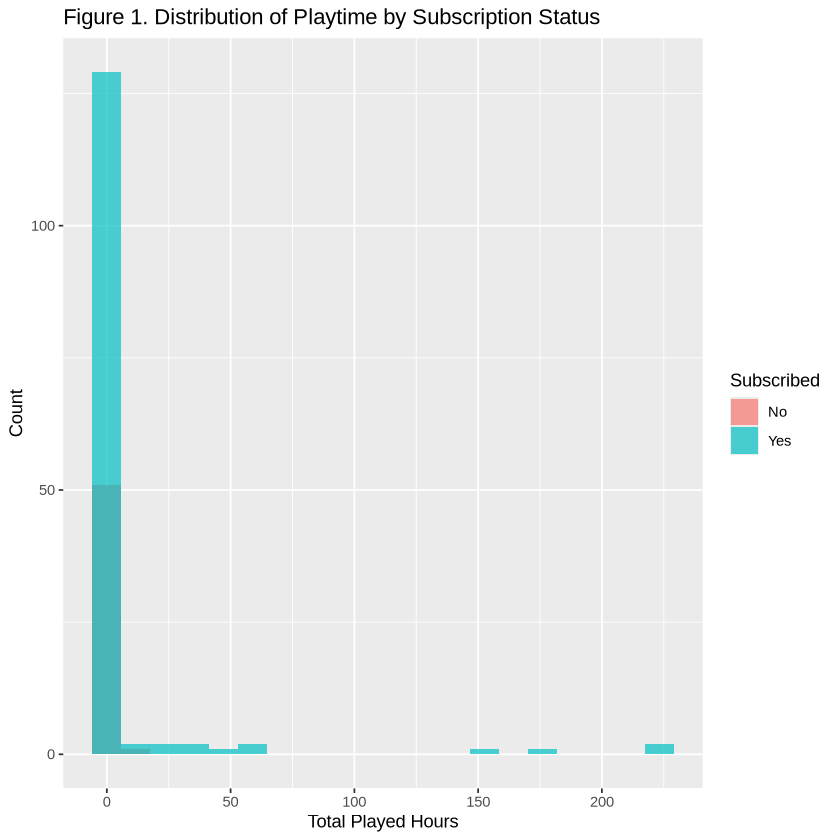

In [5]:
# visualization of data set for exploratory data analysis

# Figure 1. Histogram of playtime by subscription status
ggplot(players, aes(x = played_hours, fill = subscribe)) +
    geom_histogram(bins = 20, alpha = 0.7, position = "identity") +
    labs(title = "Figure 1. Distribution of Playtime by Subscription Status",
        x = "Total Played Hours",
        y = "Count",
        fill = "Subscribed")

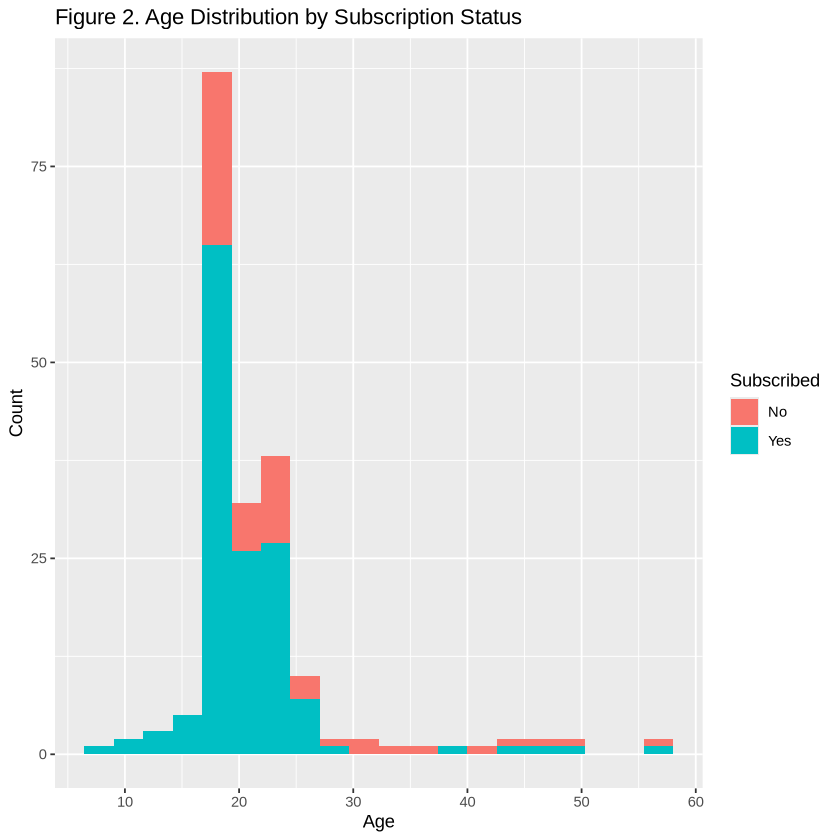

In [6]:
# Figure 2. histogram of age by subscription status
ggplot(players, aes(x = Age, fill = subscribe)) +
  geom_histogram(bins = 20) +
  labs(title = "Figure 2. Age Distribution by Subscription Status",
       x = "Age",
       y = "Count",
       fill = "Subscribed")


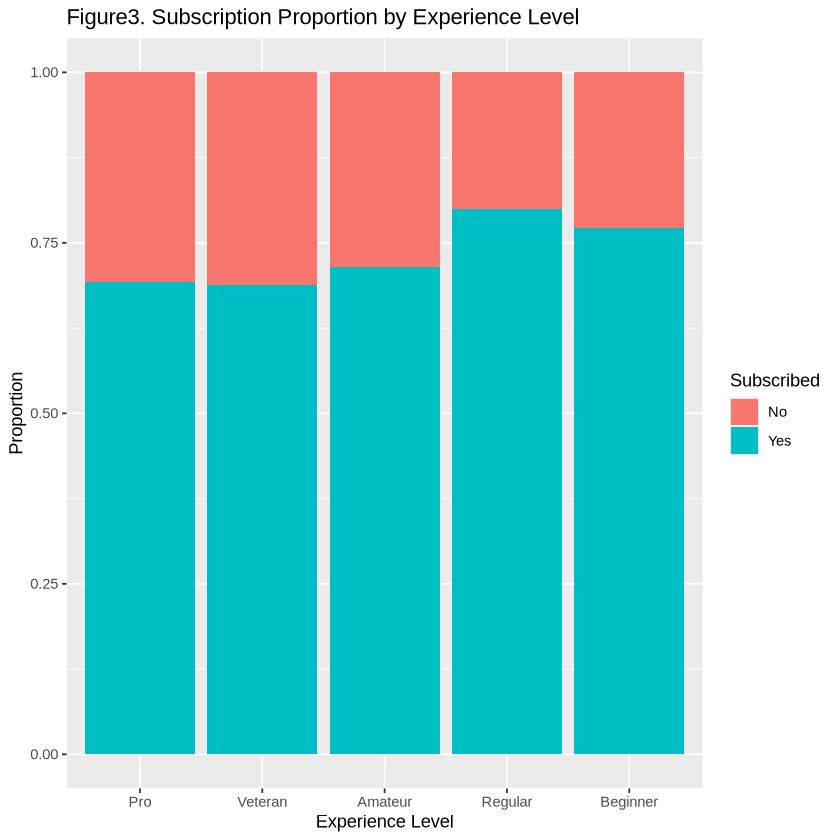

In [7]:
# Figure 3. Subscription proportion by experience level
players |>
  count(experience, subscribe) |>
  group_by(experience) |>
  mutate(prop = n / sum(n)) |>
  ggplot(aes(x = experience, y = prop, fill = subscribe)) +
  geom_bar(stat = "identity") +
  labs(
    title = "Figure3. Subscription Proportion by Experience Level",
    x = "Experience Level",
    y = "Proportion",
    fill = "Subscribed")

Classification Analysis

In [8]:
# classification data analysis (code from Yingnian)

# Data splitting
set.seed(123)
players_split <- initial_split(players, prop = 0.7, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

# Recipe for modeling (only numeric predictors, to avoid scale errors)
player_recipe <- recipe(subscribe ~ played_hours + Age, data = players_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

# KNN model specification (to be tuned)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_mode("classification") |>
  set_engine("kknn")

# Workflow
knn_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec)

In [9]:
# Cross-validation folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

# Tuning grid for K values
k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5))

# Tune KNN
knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = players_vfold, grid = k_vals) |>
  collect_metrics()
accuracies <- knn_results |>
  filter(.metric == "accuracy")
accuracies

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5171347,5,0.07272137,Preprocessor1_Model01
6,accuracy,binary,0.5986162,5,0.05898479,Preprocessor1_Model02
11,accuracy,binary,0.7268824,5,0.02537147,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
86,accuracy,binary,0.7334554,5,0.005166822,Preprocessor1_Model18
91,accuracy,binary,0.7334554,5,0.005166822,Preprocessor1_Model19
96,accuracy,binary,0.7334554,5,0.005166822,Preprocessor1_Model20


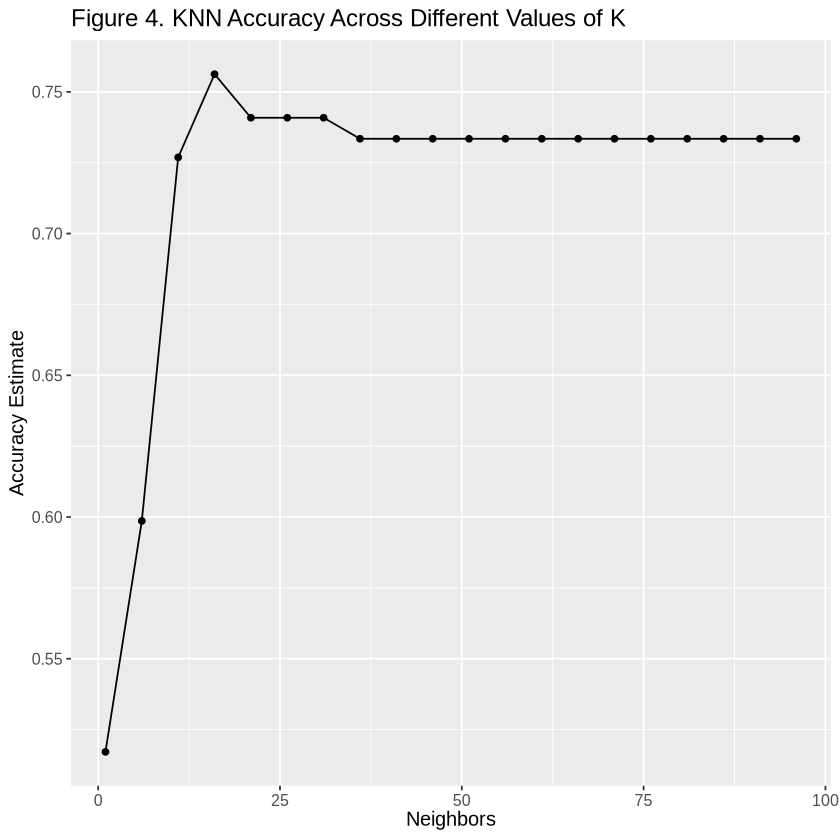

In [10]:
# Figure 4. KNN Accuracy Across Different Values of K
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(title = "Figure 4. KNN Accuracy Across Different Values of K",
       x = "Neighbors", 
       y = "Accuracy Estimate") +
  theme(text = element_text(size = 12))

accuracy_vs_k

In [11]:
# Select best K
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 16

In [12]:
# Fit final KNN model
final_knn_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_knn_spec) |>
  fit(data = players_train)

In [13]:
# Predictions on test set + accuracy, confusion matrix, precision, recall
player_test_predictions <- predict(knn_fit, players_test) |>
  bind_cols(players_test)

# Accuracy
player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7288136


In [14]:
# Confusion matrix
player_test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)

          Truth
Prediction No Yes
       No   2   2
       Yes 14  41

In [15]:
# Precision
player_test_predictions |>
  precision(truth = subscribe, estimate = .pred_class)

# Recall
player_test_predictions |>
  recall(truth = subscribe, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.5


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.125


## Discussion:
**summarize what you found**
- discuss whether this is what you expected to find
- discuss what impact could such findings have
- discuss what future questions could this lead to


## References
You may include references if necessary, as long as they all have a consistent citation style.

Pacific Laboratory of Artificial Intelligence. (2025). PLAICraft. https://plaicraft.ai/ 